Dataframe tenistas

In [167]:
import pandas as pd
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, TimeSeriesSplit,cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
import random
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate # validación cruzada
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder


Librerias

In [168]:
def df_jugador(jugador, masc):

    filtro_jugador = (masc['jugadorA'] == jugador) | (masc['jugadorB'] == jugador)
    df_jugador = masc[filtro_jugador].copy()

    df_jugador_A = df_jugador[df_jugador['jugadorA'] == jugador].copy()
    df_jugador_B = df_jugador[df_jugador['jugadorB'] == jugador].copy()

    columnas_A = [col for col in df_jugador.columns if col.endswith('A')]
    columnas_B = [col for col in df_jugador.columns if col.endswith('B')]
    mapeo_columnas = {**{col_a: col_b for col_a, col_b in zip(columnas_A, columnas_B)},
                    **{col_b: col_a for col_a, col_b in zip(columnas_A, columnas_B)}}

    df_jugador_B_invertido = df_jugador_B.rename(columns=mapeo_columnas)

    df = pd.concat([df_jugador_A, df_jugador_B_invertido], ignore_index=True)

    df = df[df['acesA'].notna() & df['acesB'].notna()]

    if 'fecha' in df.columns:
        df = df.sort_values('fecha', ascending=False)

    return df

def df_jugador_superficie(jugador, masc, sup):

    filtro_jugador = (masc['jugadorA'] == jugador) | (masc['jugadorB'] == jugador)
    df_jugador = masc[filtro_jugador].copy()

    df_jugador_A = df_jugador[df_jugador['jugadorA'] == jugador].copy()
    df_jugador_B = df_jugador[df_jugador['jugadorB'] == jugador].copy()

    columnas_A = [col for col in df_jugador.columns if col.endswith('A')]
    columnas_B = [col for col in df_jugador.columns if col.endswith('B')]
    mapeo_columnas = {**{col_a: col_b for col_a, col_b in zip(columnas_A, columnas_B)},
                    **{col_b: col_a for col_a, col_b in zip(columnas_A, columnas_B)}}

    df_jugador_B_invertido = df_jugador_B.rename(columns=mapeo_columnas)

    df_final = pd.concat([df_jugador_A, df_jugador_B_invertido], ignore_index=True)

    df = df_final[df_final['superficie'] == sup]

    df = df[df['acesA'].notna() & df['acesB'].notna()]

    if 'fecha' in df.columns:
        df = df.sort_values('fecha', ascending=False)

    return df

def promedio_ponderado(df):
    df = df.copy()

    if df.empty:
        return None

    a = df['fecha'].dt.year
    df['peso'] = a.apply(lambda x: 2 if x == 2025 else 1)

    # Columnas numéricas que vamos a promediar (ignorando 'peso')
    columnas_numericas = df.select_dtypes(include='number').columns.drop('peso')

    # Media ponderada
    media_ponderada = {}
    media_ponderada['jugador'] = df['jugadorA'][0]
    for col in columnas_numericas:
        media_ponderada[col] = (df[col] * df['peso']).sum() / df['peso'].sum()

    

    return pd.DataFrame([media_ponderada])


Lectura datos

In [169]:
df = pd.read_csv(".\\data\\data2\\datosmasc_2025-06-18.csv")

print(df['superficie'].unique())

df['cuotaA'] = df['cuotaA'].replace('-', np.nan)
df['cuotaB'] = df['cuotaB'].replace('-', np.nan)
df['cuotaA'] = df['cuotaA'].astype(float)
df['cuotaB'] = df['cuotaB'].astype(float)

#c = ['setsA', 'setsB', 'porcentajePuntosGanadosAlRestoConPrimerSaqueB', 'porcentajePuntosGanadosAlRestoConSegundoSaqueB', 'porcentajePuntosGanadosB', 'porcentajeJuegosGanadosB', 'porcentajeJuegosGanadosPrimerSaqueB',
#     'porcentajeJuegosGanadosSegundoSaqueB', 'porcentajePuntosGanadosAlRestoB', 'porcentajePuntosBreakConvertidosB', 'porcentajePuntosGanadosAlSaqueB', 'porcentajeJuegosGanadosAlSaqueB', 'porcentajeJuegosGanadosAlRestoB']
#df = df.drop(columns = c)

df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')


# Crear un diccionario con un DataFrame por cada valor único
dfs_por_categoria = {valor: df[df['superficie'] == valor].copy() for valor in df['superficie'].unique()}

hierba = dfs_por_categoria['Grass']
dura = dfs_por_categoria['Hard']
tierra = dfs_por_categoria['Clay']

hierba['fecha'] = pd.to_datetime(hierba['fecha'], errors='coerce')
dura['fecha'] = pd.to_datetime(dura['fecha'], errors='coerce')
tierra['fecha'] = pd.to_datetime(tierra['fecha'], errors='coerce')



pd.set_option('display.max_columns', None)
display(hierba.head())

['Clay' 'Grass' 'Hard' 'Carpet']


,torneo,jugadorA,jugadorB,setsA,setsB,fecha,acesA,acesB,porcentajePrimerSaqueA,porcentajePrimerSaqueB,porcentajeBreakPointsSalvadosA,porcentajeBreakPointsSalvadosB,porcentajePuntosGanadosAlRestoConPrimerSaqueA,porcentajePuntosGanadosAlRestoConPrimerSaqueB,porcentajePuntosGanadosAlRestoConSegundoSaqueA,porcentajePuntosGanadosAlRestoConSegundoSaqueB,porcentajePuntosGanadosA,porcentajePuntosGanadosB,porcentajeJuegosGanadosA,porcentajeJuegosGanadosB,cuotaA,cuotaB,dobleA,dobleB,porcentajeJuegosGanadosPrimerSaqueA,porcentajeJuegosGanadosPrimerSaqueB,porcentajeJuegosGanadosSegundoSaqueA,porcentajeJuegosGanadosSegundoSaqueB,porcentajePuntosGanadosAlRestoA,porcentajePuntosGanadosAlRestoB,porcentajePuntosBreakConvertidosA,porcentajePuntosBreakConvertidosB,porcentajePuntosGanadosAlSaqueA,porcentajePuntosGanadosAlSaqueB,porcentajeJuegosGanadosAlSaqueA,porcentajeJuegosGanadosAlSaqueB,porcentajeJuegosGanadosAlRestoA,porcentajeJuegosGanadosAlRestoB,superficie,hora,sets,ganador
23,nottingham,Choinski J.,Kachmazov A.,2,1,2025-06-15,9.0,10.0,58.0,57.0,83.0,71.0,19.0,19.0,57.0,44.0,52.0,48.0,53.0,47.0,2.15,1.6,5.0,12.0,81.0,81.0,56.0,43.0,35.0,30.0,29.0,17.0,70.0,65.0,94.0,89.0,11.0,6.0,Grass,14:55,3,0
25,nottingham,Gigante M.,Shimabukuro S.,2,1,2025-06-15,6.0,4.0,63.0,59.0,80.0,73.0,30.0,25.0,57.0,50.0,53.0,47.0,57.0,43.0,NaN,NaN,5.0,4.0,75.0,70.0,50.0,43.0,41.0,34.0,27.0,20.0,66.0,59.0,93.0,79.0,21.0,7.0,Grass,14:15,3,0
26,nottingham,Lestienne C.,Wong C.,0,2,2025-06-15,3.0,6.0,65.0,64.0,40.0,67.0,27.0,31.0,35.0,48.0,47.0,53.0,41.0,59.0,NaN,NaN,1.0,2.0,69.0,73.0,52.0,65.0,30.0,37.0,33.0,60.0,63.0,70.0,73.0,91.0,9.0,27.0,Grass,14:40,2,1
27,nottingham,Ajdukovic D.,Grenier H.,1,2,2025-06-15,8.0,14.0,64.0,74.0,57.0,83.0,23.0,21.0,60.0,55.0,49.0,51.0,43.0,57.0,1.60,2.1,2.0,7.0,79.0,77.0,45.0,40.0,33.0,33.0,17.0,43.0,67.0,67.0,80.0,93.0,7.0,20.0,Grass,14:40,3,1
28,nottingham,Gigante M.,Wong C.,2,1,2025-06-15,2.0,14.0,69.0,60.0,71.0,63.0,27.0,23.0,54.0,52.0,52.0,48.0,54.0,46.0,1.45,2.5,2.0,3.0,77.0,73.0,48.0,46.0,38.0,32.0,38.0,29.0,68.0,62.0,86.0,79.0,21.0,14.0,Grass,17:55,3,0


In [170]:
jugadorA_stats = hierba[[
    'torneo','jugadorA', 'fecha','superficie','hora','sets','cuotaA','acesA', 'dobleA', 'porcentajePrimerSaqueA','porcentajeBreakPointsSalvadosA','porcentajePuntosGanadosAlRestoConPrimerSaqueA','porcentajePuntosGanadosAlRestoConSegundoSaqueA',
    'porcentajePuntosGanadosA','porcentajeJuegosGanadosA','porcentajeJuegosGanadosPrimerSaqueA','porcentajeJuegosGanadosSegundoSaqueA','porcentajePuntosGanadosAlRestoA','porcentajePuntosBreakConvertidosA',
    'porcentajePuntosGanadosAlSaqueA','porcentajeJuegosGanadosAlSaqueA','porcentajeJuegosGanadosAlRestoA','ganador'
]].rename(columns={
    'jugadorA': 'jugador',
    'cuotaA':'cuota',
    'acesA': 'aces',
    'dobleA': 'dobles',
    'porcentajePrimerSaqueA': 'primerSaque',
    'porcentajeBreakPointsSalvadosA':'breakPointsSalvados',
    'porcentajePuntosGanadosAlRestoConPrimerSaqueA':'puntosGanadosAlRestoConPrimerSaque',
    'porcentajePuntosGanadosAlRestoConSegundoSaqueA':'puntosGanadosRestoSegundoSaque',
    'porcentajePuntosGanadosA':'puntosGanados',
    'porcentajeJuegosGanadosA':'juegosGanados',
    'porcentajeJuegosGanadosPrimerSaqueA':'juegosGanadosPrimerSaque',
    'porcentajeJuegosGanadosSegundoSaqueA':'juegosGanadosSegundoSaque',
    'porcentajePuntosGanadosAlRestoA':'puntosGanadosAlResto',
    'porcentajePuntosBreakConvertidosA':'puntosBreakConvertidos',
    'porcentajePuntosGanadosAlSaqueA':'puntosGanadosAlSaque',
    'porcentajeJuegosGanadosAlSaqueA':'juegosGanadosAlSaque',
    'porcentajeJuegosGanadosAlRestoA':'juegosGanadosAlResto',
})

# Para jugador 2
jugadorB_stats = hierba[[
    'torneo','jugadorB', 'fecha','superficie','hora','sets','cuotaB','acesB', 'dobleB', 'porcentajePrimerSaqueB', 'porcentajeBreakPointsSalvadosB','porcentajePuntosGanadosAlRestoConPrimerSaqueB',
    'porcentajePuntosGanadosAlRestoConSegundoSaqueB','porcentajePuntosGanadosB','porcentajeJuegosGanadosB','porcentajeJuegosGanadosPrimerSaqueB','porcentajeJuegosGanadosSegundoSaqueB','porcentajePuntosGanadosAlRestoB',
    'porcentajePuntosBreakConvertidosB','porcentajePuntosGanadosAlSaqueB','porcentajeJuegosGanadosAlSaqueB','porcentajeJuegosGanadosAlRestoB','ganador'
]].rename(columns={
    'jugadorB': 'jugador',
    'cuotaB':'cuota',
    'acesB': 'aces',
    'dobleB': 'dobles',
    'porcentajePrimerSaqueB': 'primerSaque',
    'porcentajeBreakPointsSalvadosB':'breakPointsSalvados',
    'porcentajePuntosGanadosAlRestoConPrimerSaqueB':'puntosGanadosAlRestoConPrimerSaque',
    'porcentajePuntosGanadosAlRestoConSegundoSaqueB':'puntosGanadosRestoSegundoSaque',
    'porcentajePuntosGanadosB':'puntosGanados',
    'porcentajeJuegosGanadosB':'juegosGanados',
    'porcentajeJuegosGanadosPrimerSaqueB':'juegosGanadosPrimerSaque',
    'porcentajeJuegosGanadosSegundoSaqueB':'juegosGanadosSegundoSaque',
    'porcentajePuntosGanadosAlRestoB':'puntosGanadosAlResto',
    'porcentajePuntosBreakConvertidosB':'puntosBreakConvertidos',
    'porcentajePuntosGanadosAlSaqueB':'puntosGanadosAlSaque',
    'porcentajeJuegosGanadosAlSaqueB':'juegosGanadosAlSaque',
    'porcentajeJuegosGanadosAlRestoB':'juegosGanadosAlResto',
})

# Concatenamos ambos
est = pd.concat([jugadorA_stats, jugadorB_stats], ignore_index=True)

est = est[~est['cuota'].isna()]

In [171]:
hierba

,torneo,jugadorA,jugadorB,setsA,setsB,fecha,acesA,acesB,porcentajePrimerSaqueA,porcentajePrimerSaqueB,porcentajeBreakPointsSalvadosA,porcentajeBreakPointsSalvadosB,porcentajePuntosGanadosAlRestoConPrimerSaqueA,porcentajePuntosGanadosAlRestoConPrimerSaqueB,porcentajePuntosGanadosAlRestoConSegundoSaqueA,porcentajePuntosGanadosAlRestoConSegundoSaqueB,porcentajePuntosGanadosA,porcentajePuntosGanadosB,porcentajeJuegosGanadosA,porcentajeJuegosGanadosB,cuotaA,cuotaB,dobleA,dobleB,porcentajeJuegosGanadosPrimerSaqueA,porcentajeJuegosGanadosPrimerSaqueB,porcentajeJuegosGanadosSegundoSaqueA,porcentajeJuegosGanadosSegundoSaqueB,porcentajePuntosGanadosAlRestoA,porcentajePuntosGanadosAlRestoB,porcentajePuntosBreakConvertidosA,porcentajePuntosBreakConvertidosB,porcentajePuntosGanadosAlSaqueA,porcentajePuntosGanadosAlSaqueB,porcentajeJuegosGanadosAlSaqueA,porcentajeJuegosGanadosAlSaqueB,porcentajeJuegosGanadosAlRestoA,porcentajeJuegosGanadosAlRestoB,superficie,hora,sets,ganador
23,nottingham,Choinski J.,Kachmazov A.,2,1,2025-06-15,9.0,10.0,58.0,57.0,83.0,71.0,19.0,19.0,57.0,44.0,52.0,48.0,53.0,47.0,2.15,1.60,5.0,12.0,81.0,81.0,56.0,43.0,35.0,30.0,29.0,17.0,70.0,65.0,94.0,89.0,11.0,6.0,Grass,14:55,3,0
25,nottingham,Gigante M.,Shimabukuro S.,2,1,2025-06-15,6.0,4.0,63.0,59.0,80.0,73.0,30.0,25.0,57.0,50.0,53.0,47.0,57.0,43.0,NaN,NaN,5.0,4.0,75.0,70.0,50.0,43.0,41.0,34.0,27.0,20.0,66.0,59.0,93.0,79.0,21.0,7.0,Grass,14:15,3,0
26,nottingham,Lestienne C.,Wong C.,0,2,2025-06-15,3.0,6.0,65.0,64.0,40.0,67.0,27.0,31.0,35.0,48.0,47.0,53.0,41.0,59.0,NaN,NaN,1.0,2.0,69.0,73.0,52.0,65.0,30.0,37.0,33.0,60.0,63.0,70.0,73.0,91.0,9.0,27.0,Grass,14:40,2,1
27,nottingham,Ajdukovic D.,Grenier H.,1,2,2025-06-15,8.0,14.0,64.0,74.0,57.0,83.0,23.0,21.0,60.0,55.0,49.0,51.0,43.0,57.0,1.60,2.10,2.0,7.0,79.0,77.0,45.0,40.0,33.0,33.0,17.0,43.0,67.0,67.0,80.0,93.0,7.0,20.0,Grass,14:40,3,1
28,nottingham,Gigante M.,Wong C.,2,1,2025-06-15,2.0,14.0,69.0,60.0,71.0,63.0,27.0,23.0,54.0,52.0,52.0,48.0,54.0,46.0,1.45,2.50,2.0,3.0,77.0,73.0,48.0,46.0,38.0,32.0,38.0,29.0,68.0,62.0,86.0,79.0,21.0,14.0,Grass,17:55,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19398,nottingham,Muller G.,Cuevas P.,1,2,2016-06-24,24.0,13.0,54.0,66.0,75.0,80.0,15.0,12.0,39.0,29.0,51.0,49.0,52.0,48.0,1.30,3.50,5.0,3.0,88.0,85.0,60.0,52.0,27.0,25.0,20.0,25.0,75.0,73.0,94.0,93.0,7.0,6.0,Grass,13:40,3,1
19399,nottingham,Anderson K.,Johnson S.,1,2,2016-06-24,21.0,13.0,67.0,67.0,67.0,50.0,22.0,18.0,33.0,38.0,49.0,51.0,50.0,50.0,1.50,2.60,4.0,2.0,82.0,78.0,50.0,61.0,28.0,29.0,50.0,33.0,71.0,72.0,88.0,88.0,12.0,12.0,Grass,13:15,3,1
19400,nottingham,Baghdatis M.,Cuevas P.,1,2,2016-06-23,13.0,11.0,60.0,61.0,67.0,80.0,27.0,15.0,42.0,38.0,51.0,49.0,50.0,50.0,1.25,3.75,7.0,6.0,85.0,73.0,45.0,46.0,37.0,31.0,20.0,33.0,69.0,63.0,88.0,88.0,13.0,13.0,Grass,14:40,3,1
19401,nottingham,Muller G.,Dolgopolov A.,2,0,2016-06-23,14.0,3.0,62.0,64.0,0.0,67.0,43.0,9.0,29.0,57.0,55.0,45.0,63.0,37.0,1.66,2.10,2.0,2.0,91.0,57.0,33.0,62.0,41.0,31.0,33.0,100.0,69.0,59.0,90.0,67.0,33.0,10.0,Grass,13:15,2,0


In [172]:
jugadores = list(set(hierba['jugadorA'].unique()).union(hierba['jugadorB'].unique()))

estadisticas_hierba = pd.DataFrame()

for jugador in jugadores:
    resumen = promedio_ponderado(df_jugador_superficie(jugador, hierba, 'Grass'))
    if resumen is not None:
        resumen['jugador'] = jugador
        estadisticas_hierba = pd.concat([estadisticas_hierba, resumen], ignore_index=True)

estadisticas = pd.DataFrame()

for jugador in jugadores:
    resumen = promedio_ponderado(df_jugador(jugador, df))
    if resumen is not None:
        resumen['jugador'] = jugador
        estadisticas = pd.concat([estadisticas, resumen], ignore_index=True)

estadisticas

,jugador,setsA,setsB,acesA,acesB,porcentajePrimerSaqueA,porcentajePrimerSaqueB,porcentajeBreakPointsSalvadosA,porcentajeBreakPointsSalvadosB,porcentajePuntosGanadosAlRestoConPrimerSaqueA,porcentajePuntosGanadosAlRestoConPrimerSaqueB,porcentajePuntosGanadosAlRestoConSegundoSaqueA,porcentajePuntosGanadosAlRestoConSegundoSaqueB,porcentajePuntosGanadosA,porcentajePuntosGanadosB,porcentajeJuegosGanadosA,porcentajeJuegosGanadosB,cuotaA,cuotaB,dobleA,dobleB,porcentajeJuegosGanadosPrimerSaqueA,porcentajeJuegosGanadosPrimerSaqueB,porcentajeJuegosGanadosSegundoSaqueA,porcentajeJuegosGanadosSegundoSaqueB,porcentajePuntosGanadosAlRestoA,porcentajePuntosGanadosAlRestoB,porcentajePuntosBreakConvertidosA,porcentajePuntosBreakConvertidosB,porcentajePuntosGanadosAlSaqueA,porcentajePuntosGanadosAlSaqueB,porcentajeJuegosGanadosAlSaqueA,porcentajeJuegosGanadosAlSaqueB,porcentajeJuegosGanadosAlRestoA,porcentajeJuegosGanadosAlRestoB,sets,ganador
0,Marozsan F.,1.351648,1.252747,5.010989,7.164835,63.593407,62.054945,58.351648,56.956044,29.384615,28.472527,50.538462,46.593407,51.087912,48.923077,52.406593,47.593407,2.536044,2.271758,2.417582,3.054945,71.857143,70.681319,52.791209,49.197802,37.472527,35.307692,39.780220,38.373626,64.692308,62.527473,80.307692,75.857143,24.241758,19.736264,2.604396,0.472527
1,Coric B.,1.470000,0.940000,5.230000,5.090000,60.530000,60.380000,60.740000,55.260000,31.240000,25.540000,51.900000,46.110000,52.790000,47.230000,54.710000,45.290000,1.641600,3.031800,1.980000,2.960000,74.510000,68.770000,53.560000,47.900000,39.500000,33.780000,44.760000,35.300000,66.220000,60.500000,82.690000,73.350000,26.720000,17.380000,2.410000,0.510000
2,Ficovich J. P.,1.221429,1.128571,4.321429,4.000000,60.400000,60.728571,58.578571,54.292857,31.514286,30.807143,48.457143,46.528571,50.314286,49.707143,50.842857,49.157143,1.992071,2.505071,2.135714,3.107143,69.235714,68.557143,52.057143,50.414286,38.642857,37.892857,39.328571,38.614286,62.114286,61.371429,75.528571,74.207143,25.857143,24.542857,2.350000,0.471429
3,Gaubas V.,1.382353,1.137255,2.705882,2.676471,68.078431,62.411765,49.852941,49.715686,32.176471,34.676471,51.107843,48.931373,50.245098,49.784314,50.970588,49.029412,2.416176,1.987941,1.823529,2.901961,65.323529,67.833333,51.098039,48.931373,39.333333,39.352941,45.441176,47.254902,60.647059,60.666667,73.323529,71.411765,28.637255,26.764706,2.519608,0.450980
4,Brouwer G.,0.878788,1.333333,4.606061,5.909091,68.939394,60.757576,55.515152,52.969697,25.151515,31.424242,48.606061,51.939394,48.303030,51.727273,47.121212,52.878788,1.773030,3.019394,2.515152,2.575758,68.606061,74.848485,46.818182,50.575758,34.818182,38.212121,28.909091,44.575758,61.818182,65.181818,73.060606,79.090909,20.969697,26.939394,2.212121,0.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,Lajal M.,1.515152,0.929293,5.575758,4.909091,64.858586,61.949495,57.141414,55.757576,32.262626,27.727273,52.101010,46.050505,52.595960,47.404040,55.656566,44.343434,1.883333,2.547374,3.272727,3.313131,72.555556,67.737374,53.979798,47.898990,39.939394,34.222222,42.252525,34.818182,65.838384,60.060606,82.454545,71.727273,28.363636,17.555556,2.444444,0.393939
428,Valkusz M.,1.214286,1.142857,2.000000,3.357143,59.642857,61.142857,56.642857,44.928571,35.071429,37.071429,57.142857,48.071429,51.000000,49.071429,51.928571,48.071429,1.635714,2.330000,3.500000,2.785714,63.000000,64.928571,50.714286,42.428571,44.285714,42.428571,47.928571,43.357143,57.571429,55.714286,66.571429,62.928571,37.142857,33.428571,2.357143,0.500000
429,Shang J.,1.697674,0.906977,6.023256,9.279070,62.860465,62.581395,56.395349,60.209302,26.930233,24.837209,54.441860,46.883721,51.976744,48.023256,54.697674,45.302326,1.947442,2.781163,2.604651,3.279070,75.232558,73.069767,53.209302,45.627907,37.116279,32.674419,39.883721,34.302326,67.348837,62.906977,86.232558,76.534884,23.488372,13.837209,2.604651,0.488372
43

In [173]:
estadisticas = estadisticas.rename(columns={
    'acesA': 'aces_hechos',
    'acesB': 'aces_recibidos',
    'dobleA': 'dobles_hechas',
    'dobleB':'dobles_recibidas'
})

In [174]:
columnas_basicas = ['jugadorA', 'jugadorB', 'ganador', 'fecha', 'superficie', 'sets']
df2 = df[columnas_basicas]

display(estadisticas.head())

# 1. Renombrar df_stats para luego poder diferenciar A y B
df_stats_A = estadisticas.rename(columns=lambda x: f"{x}_A" if x != 'jugador' else 'jugadorA')
df_stats_B = estadisticas.rename(columns=lambda x: f"{x}_B" if x != 'jugador' else 'jugadorB')

display(df_stats_A.head())
display(df_stats_B.head())

# 2. Hacer merge con df_partidos para traer las stats de jugadorA y jugadorB
df_merged = df2.merge(df_stats_A, on='jugadorA', how='left')
df_merged = df_merged.merge(df_stats_B, on='jugadorB', how='left')

df_merged = df_merged.dropna(subset=[col for col in df_merged.columns if col.endswith('_A') or col.endswith('_B')])

print(len(df_merged))

df_merged.head()

,jugador,setsA,setsB,aces_hechos,aces_recibidos,porcentajePrimerSaqueA,porcentajePrimerSaqueB,porcentajeBreakPointsSalvadosA,porcentajeBreakPointsSalvadosB,porcentajePuntosGanadosAlRestoConPrimerSaqueA,porcentajePuntosGanadosAlRestoConPrimerSaqueB,porcentajePuntosGanadosAlRestoConSegundoSaqueA,porcentajePuntosGanadosAlRestoConSegundoSaqueB,porcentajePuntosGanadosA,porcentajePuntosGanadosB,porcentajeJuegosGanadosA,porcentajeJuegosGanadosB,cuotaA,cuotaB,dobles_hechas,dobles_recibidas,porcentajeJuegosGanadosPrimerSaqueA,porcentajeJuegosGanadosPrimerSaqueB,porcentajeJuegosGanadosSegundoSaqueA,porcentajeJuegosGanadosSegundoSaqueB,porcentajePuntosGanadosAlRestoA,porcentajePuntosGanadosAlRestoB,porcentajePuntosBreakConvertidosA,porcentajePuntosBreakConvertidosB,porcentajePuntosGanadosAlSaqueA,porcentajePuntosGanadosAlSaqueB,porcentajeJuegosGanadosAlSaqueA,porcentajeJuegosGanadosAlSaqueB,porcentajeJuegosGanadosAlRestoA,porcentajeJuegosGanadosAlRestoB,sets,ganador
0,Marozsan F.,1.351648,1.252747,5.010989,7.164835,63.593407,62.054945,58.351648,56.956044,29.384615,28.472527,50.538462,46.593407,51.087912,48.923077,52.406593,47.593407,2.536044,2.271758,2.417582,3.054945,71.857143,70.681319,52.791209,49.197802,37.472527,35.307692,39.780220,38.373626,64.692308,62.527473,80.307692,75.857143,24.241758,19.736264,2.604396,0.472527
1,Coric B.,1.470000,0.940000,5.230000,5.090000,60.530000,60.380000,60.740000,55.260000,31.240000,25.540000,51.900000,46.110000,52.790000,47.230000,54.710000,45.290000,1.641600,3.031800,1.980000,2.960000,74.510000,68.770000,53.560000,47.900000,39.500000,33.780000,44.760000,35.300000,66.220000,60.500000,82.690000,73.350000,26.720000,17.380000,2.410000,0.510000
2,Ficovich J. P.,1.221429,1.128571,4.321429,4.000000,60.400000,60.728571,58.578571,54.292857,31.514286,30.807143,48.457143,46.528571,50.314286,49.707143,50.842857,49.157143,1.992071,2.505071,2.135714,3.107143,69.235714,68.557143,52.057143,50.414286,38.642857,37.892857,39.328571,38.614286,62.114286,61.371429,75.528571,74.207143,25.857143,24.542857,2.350000,0.471429
3,Gaubas V.,1.382353,1.137255,2.705882,2.676471,68.078431,62.411765,49.852941,49.715686,32.176471,34.676471,51.107843,48.931373,50.245098,49.784314,50.970588,49.029412,2.416176,1.987941,1.823529,2.901961,65.323529,67.833333,51.098039,48.931373,39.333333,39.352941,45.441176,47.254902,60.647059,60.666667,73.323529,71.411765,28.637255,26.764706,2.519608,0.450980
4,Brouwer G.,0.878788,1.333333,4.606061,5.909091,68.939394,60.757576,55.515152,52.969697,25.151515,31.424242,48.606061,51.939394,48.303030,51.727273,47.121212,52.878788,1.773030,3.019394,2.515152,2.575758,68.606061,74.848485,46.818182,50.575758,34.818182,38.212121,28.909091,44.575758,61.818182,65.181818,73.060606,79.090909,20.969697,26.939394,2.212121,0.454545


,jugadorA,setsA_A,setsB_A,aces_hechos_A,aces_recibidos_A,porcentajePrimerSaqueA_A,porcentajePrimerSaqueB_A,porcentajeBreakPointsSalvadosA_A,porcentajeBreakPointsSalvadosB_A,porcentajePuntosGanadosAlRestoConPrimerSaqueA_A,porcentajePuntosGanadosAlRestoConPrimerSaqueB_A,porcentajePuntosGanadosAlRestoConSegundoSaqueA_A,porcentajePuntosGanadosAlRestoConSegundoSaqueB_A,porcentajePuntosGanadosA_A,porcentajePuntosGanadosB_A,porcentajeJuegosGanadosA_A,porcentajeJuegosGanadosB_A,cuotaA_A,cuotaB_A,dobles_hechas_A,dobles_recibidas_A,porcentajeJuegosGanadosPrimerSaqueA_A,porcentajeJuegosGanadosPrimerSaqueB_A,porcentajeJuegosGanadosSegundoSaqueA_A,porcentajeJuegosGanadosSegundoSaqueB_A,porcentajePuntosGanadosAlRestoA_A,porcentajePuntosGanadosAlRestoB_A,porcentajePuntosBreakConvertidosA_A,porcentajePuntosBreakConvertidosB_A,porcentajePuntosGanadosAlSaqueA_A,porcentajePuntosGanadosAlSaqueB_A,porcentajeJuegosGanadosAlSaqueA_A,porcentajeJuegosGanadosAlSaqueB_A,porcentajeJuegosGanadosAlRestoA_A,porcentajeJuegosGanadosAlRestoB_A,sets_A,ganador_A
0,Marozsan F.,1.351648,1.252747,5.010989,7.164835,63.593407,62.054945,58.351648,56.956044,29.384615,28.472527,50.538462,46.593407,51.087912,48.923077,52.406593,47.593407,2.536044,2.271758,2.417582,3.054945,71.857143,70.681319,52.791209,49.197802,37.472527,35.307692,39.780220,38.373626,64.692308,62.527473,80.307692,75.857143,24.241758,19.736264,2.604396,0.472527
1,Coric B.,1.470000,0.940000,5.230000,5.090000,60.530000,60.380000,60.740000,55.260000,31.240000,25.540000,51.900000,46.110000,52.790000,47.230000,54.710000,45.290000,1.641600,3.031800,1.980000,2.960000,74.510000,68.770000,53.560000,47.900000,39.500000,33.780000,44.760000,35.300000,66.220000,60.500000,82.690000,73.350000,26.720000,17.380000,2.410000,0.510000
2,Ficovich J. P.,1.221429,1.128571,4.321429,4.000000,60.400000,60.728571,58.578571,54.292857,31.514286,30.807143,48.457143,46.528571,50.314286,49.707143,50.842857,49.157143,1.992071,2.505071,2.135714,3.107143,69.235714,68.557143,52.057143,50.414286,38.642857,37.892857,39.328571,38.614286,62.114286,61.371429,75.528571,74.207143,25.857143,24.542857,2.350000,0.471429
3,Gaubas V.,1.382353,1.137255,2.705882,2.676471,68.078431,62.411765,49.852941,49.715686,32.176471,34.676471,51.107843,48.931373,50.245098,49.784314,50.970588,49.029412,2.416176,1.987941,1.823529,2.901961,65.323529,67.833333,51.098039,48.931373,39.333333,39.352941,45.441176,47.254902,60.647059,60.666667,73.323529,71.411765,28.637255,26.764706,2.519608,0.450980
4,Brouwer G.,0.878788,1.333333,4.606061,5.909091,68.939394,60.757576,55.515152,52.969697,25.151515,31.424242,48.606061,51.939394,48.303030,51.727273,47.121212,52.878788,1.773030,3.019394,2.515152,2.575758,68.606061,74.848485,46.818182,50.575758,34.818182,38.212121,28.909091,44.575758,61.818182,65.181818,73.060606,79.090909,20.969697,26.939394,2.212121,0.454545


,jugadorB,setsA_B,setsB_B,aces_hechos_B,aces_recibidos_B,porcentajePrimerSaqueA_B,porcentajePrimerSaqueB_B,porcentajeBreakPointsSalvadosA_B,porcentajeBreakPointsSalvadosB_B,porcentajePuntosGanadosAlRestoConPrimerSaqueA_B,porcentajePuntosGanadosAlRestoConPrimerSaqueB_B,porcentajePuntosGanadosAlRestoConSegundoSaqueA_B,porcentajePuntosGanadosAlRestoConSegundoSaqueB_B,porcentajePuntosGanadosA_B,porcentajePuntosGanadosB_B,porcentajeJuegosGanadosA_B,porcentajeJuegosGanadosB_B,cuotaA_B,cuotaB_B,dobles_hechas_B,dobles_recibidas_B,porcentajeJuegosGanadosPrimerSaqueA_B,porcentajeJuegosGanadosPrimerSaqueB_B,porcentajeJuegosGanadosSegundoSaqueA_B,porcentajeJuegosGanadosSegundoSaqueB_B,porcentajePuntosGanadosAlRestoA_B,porcentajePuntosGanadosAlRestoB_B,porcentajePuntosBreakConvertidosA_B,porcentajePuntosBreakConvertidosB_B,porcentajePuntosGanadosAlSaqueA_B,porcentajePuntosGanadosAlSaqueB_B,porcentajeJuegosGanadosAlSaqueA_B,porcentajeJuegosGanadosAlSaqueB_B,porcentajeJuegosGanadosAlRestoA_B,porcentajeJuegosGanadosAlRestoB_B,sets_B,ganador_B
0,Marozsan F.,1.351648,1.252747,5.010989,7.164835,63.593407,62.054945,58.351648,56.956044,29.384615,28.472527,50.538462,46.593407,51.087912,48.923077,52.406593,47.593407,2.536044,2.271758,2.417582,3.054945,71.857143,70.681319,52.791209,49.197802,37.472527,35.307692,39.780220,38.373626,64.692308,62.527473,80.307692,75.857143,24.241758,19.736264,2.604396,0.472527
1,Coric B.,1.470000,0.940000,5.230000,5.090000,60.530000,60.380000,60.740000,55.260000,31.240000,25.540000,51.900000,46.110000,52.790000,47.230000,54.710000,45.290000,1.641600,3.031800,1.980000,2.960000,74.510000,68.770000,53.560000,47.900000,39.500000,33.780000,44.760000,35.300000,66.220000,60.500000,82.690000,73.350000,26.720000,17.380000,2.410000,0.510000
2,Ficovich J. P.,1.221429,1.128571,4.321429,4.000000,60.400000,60.728571,58.578571,54.292857,31.514286,30.807143,48.457143,46.528571,50.314286,49.707143,50.842857,49.157143,1.992071,2.505071,2.135714,3.107143,69.235714,68.557143,52.057143,50.414286,38.642857,37.892857,39.328571,38.614286,62.114286,61.371429,75.528571,74.207143,25.857143,24.542857,2.350000,0.471429
3,Gaubas V.,1.382353,1.137255,2.705882,2.676471,68.078431,62.411765,49.852941,49.715686,32.176471,34.676471,51.107843,48.931373,50.245098,49.784314,50.970588,49.029412,2.416176,1.987941,1.823529,2.901961,65.323529,67.833333,51.098039,48.931373,39.333333,39.352941,45.441176,47.254902,60.647059,60.666667,73.323529,71.411765,28.637255,26.764706,2.519608,0.450980
4,Brouwer G.,0.878788,1.333333,4.606061,5.909091,68.939394,60.757576,55.515152,52.969697,25.151515,31.424242,48.606061,51.939394,48.303030,51.727273,47.121212,52.878788,1.773030,3.019394,2.515152,2.575758,68.606061,74.848485,46.818182,50.575758,34.818182,38.212121,28.909091,44.575758,61.818182,65.181818,73.060606,79.090909,20.969697,26.939394,2.212121,0.454545


7739


,jugadorA,jugadorB,ganador,fecha,superficie,sets,setsA_A,setsB_A,aces_hechos_A,aces_recibidos_A,porcentajePrimerSaqueA_A,porcentajePrimerSaqueB_A,porcentajeBreakPointsSalvadosA_A,porcentajeBreakPointsSalvadosB_A,porcentajePuntosGanadosAlRestoConPrimerSaqueA_A,porcentajePuntosGanadosAlRestoConPrimerSaqueB_A,porcentajePuntosGanadosAlRestoConSegundoSaqueA_A,porcentajePuntosGanadosAlRestoConSegundoSaqueB_A,porcentajePuntosGanadosA_A,porcentajePuntosGanadosB_A,porcentajeJuegosGanadosA_A,porcentajeJuegosGanadosB_A,cuotaA_A,cuotaB_A,dobles_hechas_A,dobles_recibidas_A,porcentajeJuegosGanadosPrimerSaqueA_A,porcentajeJuegosGanadosPrimerSaqueB_A,porcentajeJuegosGanadosSegundoSaqueA_A,porcentajeJuegosGanadosSegundoSaqueB_A,porcentajePuntosGanadosAlRestoA_A,porcentajePuntosGanadosAlRestoB_A,porcentajePuntosBreakConvertidosA_A,porcentajePuntosBreakConvertidosB_A,porcentajePuntosGanadosAlSaqueA_A,porcentajePuntosGanadosAlSaqueB_A,porcentajeJuegosGanadosAlSaqueA_A,porcentajeJuegosGanadosAlSaqueB_A,porcentajeJuegosGanadosAlRestoA_A,porcentajeJuegosGanadosAlRestoB_A,sets_A,ganador_A,setsA_B,setsB_B,aces_hechos_B,aces_recibidos_B,porcentajePrimerSaqueA_B,porcentajePrimerSaqueB_B,porcentajeBreakPointsSalvadosA_B,porcentajeBreakPointsSalvadosB_B,porcentajePuntosGanadosAlRestoConPrimerSaqueA_B,porcentajePuntosGanadosAlRestoConPrimerSaqueB_B,porcentajePuntosGanadosAlRestoConSegundoSaqueA_B,porcentajePuntosGanadosAlRestoConSegundoSaqueB_B,porcentajePuntosGanadosA_B,porcentajePuntosGanadosB_B,porcentajeJuegosGanadosA_B,porcentajeJuegosGanadosB_B,cuotaA_B,cuotaB_B,dobles_hechas_B,dobles_recibidas_B,porcentajeJuegosGanadosPrimerSaqueA_B,porcentajeJuegosGanadosPrimerSaqueB_B,porcentajeJuegosGanadosSegundoSaqueA_B,porcentajeJuegosGanadosSegundoSaqueB_B,porcentajePuntosGanadosAlRestoA_B,porcentajePuntosGanadosAlRestoB_B,porcentajePuntosBreakConvertidosA_B,porcentajePuntosBreakConvertidosB_B,porcentajePuntosGanadosAlSaqueA_B,porcentajePuntosGanadosAlSaqueB_B,porcentajeJuegosGanadosAlSaqueA_B,porcentajeJuegosGanadosAlSaqueB_B,porcentajeJuegosGanadosAlRestoA_B,porcentajeJuegosGanadosAlRestoB_B,sets_B,ganador_B
7,Hsu Y. H.,Brunold M.,1,2025-06-16,Clay,2,0.933333,1.186667,2.840000,4.466667,64.813333,60.973333,50.853333,54.120000,29.733333,34.746667,50.226667,47.613333,49.466667,50.533333,48.386667,51.613333,2.430800,2.198933,2.160000,2.933333,65.360000,70.320000,51.240000,48.066667,38.626667,39.733333,39.213333,46.546667,60.280000,61.373333,70.706667,74.280000,25.786667,29.360000,2.120000,0.480000,1.285714,0.976190,2.785714,3.059524,60.702381,62.952381,52.226190,56.476190,32.154762,29.476190,55.928571,50.023810,51.380952,48.619048,52.619048,47.380952,1.969643,2.322500,3.738095,2.714286,70.547619,67.892857,50.035714,44.095238,40.988095,37.678571,43.619048,43.083333,62.321429,59.035714,76.226190,70.773810,29.250000,23.821429,2.261905,0.500000
8,Barranco Cosano J.,Mikrut L.,1,2025-06-16,Clay,2,1.151163,1.220930,1.906977,3.372093,62.895349,60.488372,50.279070,51.220930,34.139535,36.127907,49.255814,50.581395,49.453488,50.546512,49.000000,51.000000,2.022442,2.107093,2.802326,2.686047,63.872093,65.860465,47.918605,48.930233,41.081395,42.069767,46.500000,45.116279,57.941860,58.930233,67.232558,69.337209,30.767442,32.813953,2.372093,0.476744,1.111111,1.222222,3.722222,3.111111,58.416667,62.833333,51.250000,51.444444,33.833333,31.638889,49.277778,52.555556,49.694444,50.277778,49.194444,50.805556,2.173333,2.406111,2.222222,2.194444,68.805556,66.166667,47.500000,50.722222,39.638889,39.944444,45.805556,48.777778,60.055556,60.388889,71.361111,72.333333,27.722222,28.666667,2.333333,0.555556
18,Ymer E.,Brancaccio R.,0,2025-06-16,Clay,3,1.286957,1.147826,4.286957,3.843478,61.513043,60.304348,58.156522,54.243478,30.400000,30.217391,49.747826,51.000000,50.173913,49.834783,50.652174,49.347826,2.022087,2.286435,3.104348,3.008696,69.886957,69.617391,48.182609,49.504348,38.426087,38.547826,44.086957,41.060870,61.460870,61.600000,75.843478,74.965217,25.104348,24.165217,2.434783,0.504

In [175]:
# porcentajePrimerSaqueA_A es el porcentaje de primer saque que el jugador A tiene
# porcentajePrimerSaqueB_A es el porcentaje de primer saque que tienen los jugadores que juegan contra el jugador A
# porcentajePrimerSaqueA_B es el porcentaje de primer saque que el jugador B tiene
# porcentajePrimerSaqueB_B es el porcentaje de primer saque que tienen los jugadores que juegan contra el jugador B

# Elegimos columnas que queremos usar
columnas = ['aces_hechos', 'aces_recibidos','dobles_hechas', 'dobles_recibidas', 'setsA', 'setsB', 'porcentajePrimerSaqueA', 'porcentajePrimerSaqueB', 'porcentajeBreakPointsSalvadosA', 'porcentajeBreakPointsSalvadosB', 
            'porcentajePuntosGanadosAlRestoConPrimerSaqueA', 'porcentajePuntosGanadosAlRestoConPrimerSaqueB','porcentajePuntosGanadosAlRestoConSegundoSaqueA', 'porcentajePuntosGanadosAlRestoConSegundoSaqueB',
         'porcentajePuntosGanadosA', 'porcentajePuntosGanadosB', 'porcentajeJuegosGanadosA', 'porcentajeJuegosGanadosB', 'cuotaA', 'cuotaB', 'porcentajeJuegosGanadosPrimerSaqueA', 'porcentajeJuegosGanadosPrimerSaqueB',
         'porcentajeJuegosGanadosSegundoSaqueA', 'porcentajeJuegosGanadosSegundoSaqueB', 'porcentajePuntosGanadosAlRestoA', 'porcentajePuntosGanadosAlRestoB', 'porcentajePuntosBreakConvertidosA', 'porcentajePuntosBreakConvertidosB',
         'porcentajePuntosGanadosAlSaqueA', 'porcentajePuntosGanadosAlSaqueB', 'porcentajeJuegosGanadosAlSaqueA', 'porcentajeJuegosGanadosAlSaqueB', 'porcentajeJuegosGanadosAlRestoA', 'porcentajeJuegosGanadosAlRestoB', 'sets','ganador'
            ]

for col in columnas:
    col_A = f"{col}_A"
    col_B = f"{col}_B"
    df_merged[f"{col}_diff"] = df_merged[col_A] - df_merged[col_B]

df_merged.head()


,jugadorA,jugadorB,ganador,fecha,superficie,sets,setsA_A,setsB_A,aces_hechos_A,aces_recibidos_A,porcentajePrimerSaqueA_A,porcentajePrimerSaqueB_A,porcentajeBreakPointsSalvadosA_A,porcentajeBreakPointsSalvadosB_A,porcentajePuntosGanadosAlRestoConPrimerSaqueA_A,porcentajePuntosGanadosAlRestoConPrimerSaqueB_A,porcentajePuntosGanadosAlRestoConSegundoSaqueA_A,porcentajePuntosGanadosAlRestoConSegundoSaqueB_A,porcentajePuntosGanadosA_A,porcentajePuntosGanadosB_A,porcentajeJuegosGanadosA_A,porcentajeJuegosGanadosB_A,cuotaA_A,cuotaB_A,dobles_hechas_A,dobles_recibidas_A,porcentajeJuegosGanadosPrimerSaqueA_A,porcentajeJuegosGanadosPrimerSaqueB_A,porcentajeJuegosGanadosSegundoSaqueA_A,porcentajeJuegosGanadosSegundoSaqueB_A,porcentajePuntosGanadosAlRestoA_A,porcentajePuntosGanadosAlRestoB_A,porcentajePuntosBreakConvertidosA_A,porcentajePuntosBreakConvertidosB_A,porcentajePuntosGanadosAlSaqueA_A,porcentajePuntosGanadosAlSaqueB_A,porcentajeJuegosGanadosAlSaqueA_A,porcentajeJuegosGanadosAlSaqueB_A,porcentajeJuegosGanadosAlRestoA_A,porcentajeJuegosGanadosAlRestoB_A,sets_A,ganador_A,setsA_B,setsB_B,aces_hechos_B,aces_recibidos_B,porcentajePrimerSaqueA_B,porcentajePrimerSaqueB_B,porcentajeBreakPointsSalvadosA_B,porcentajeBreakPointsSalvadosB_B,porcentajePuntosGanadosAlRestoConPrimerSaqueA_B,porcentajePuntosGanadosAlRestoConPrimerSaqueB_B,porcentajePuntosGanadosAlRestoConSegundoSaqueA_B,porcentajePuntosGanadosAlRestoConSegundoSaqueB_B,porcentajePuntosGanadosA_B,porcentajePuntosGanadosB_B,porcentajeJuegosGanadosA_B,porcentajeJuegosGanadosB_B,cuotaA_B,cuotaB_B,dobles_hechas_B,dobles_recibidas_B,porcentajeJuegosGanadosPrimerSaqueA_B,porcentajeJuegosGanadosPrimerSaqueB_B,porcentajeJuegosGanadosSegundoSaqueA_B,porcentajeJuegosGanadosSegundoSaqueB_B,porcentajePuntosGanadosAlRestoA_B,porcentajePuntosGanadosAlRestoB_B,porcentajePuntosBreakConvertidosA_B,porcentajePuntosBreakConvertidosB_B,porcentajePuntosGanadosAlSaqueA_B,porcentajePuntosGanadosAlSaqueB_B,porcentajeJuegosGanadosAlSaqueA_B,porcentajeJuegosGanadosAlSaqueB_B,porcentajeJuegosGanadosAlRestoA_B,porcentajeJuegosGanadosAlRestoB_B,sets_B,ganador_B,aces_hechos_diff,aces_recibidos_diff,dobles_hechas_diff,dobles_recibidas_diff,setsA_diff,setsB_diff,porcentajePrimerSaqueA_diff,porcentajePrimerSaqueB_diff,porcentajeBreakPointsSalvadosA_diff,porcentajeBreakPointsSalvadosB_diff,porcentajePuntosGanadosAlRestoConPrimerSaqueA_diff,porcentajePuntosGanadosAlRestoConPrimerSaqueB_diff,porcentajePuntosGanadosAlRestoConSegundoSaqueA_diff,porcentajePuntosGanadosAlRestoConSegundoSaqueB_diff,porcentajePuntosGanadosA_diff,porcentajePuntosGanadosB_diff,porcentajeJuegosGanadosA_diff,porcentajeJuegosGanadosB_diff,cuotaA_diff,cuotaB_diff,porcentajeJuegosGanadosPrimerSaqueA_diff,porcentajeJuegosGanadosPrimerSaqueB_diff,porcentajeJuegosGanadosSegundoSaqueA_diff,porcentajeJuegosGanadosSegundoSaqueB_diff,porcentajePuntosGanadosAlRestoA_diff,porcentajePuntosGanadosAlRestoB_diff,porcentajePuntosBreakConvertidosA_diff,porcentajePuntosBreakConvertidosB_diff,porcentajePuntosGanadosAlSaqueA_diff,porcentajePuntosGanadosAlSaqueB_diff,porcentajeJuegosGanadosAlSaqueA_diff,porcentajeJuegosGanadosAlSaqueB_diff,porcentajeJuegosGanadosAlRestoA_diff,porcentajeJuegosGanadosAlRestoB_diff,sets_diff,ganador_diff
7,Hsu Y. H.,Brunold M.,1,2025-06-16,Clay,2,0.933333,1.186667,2.840000,4.466667,64.813333,60.973333,50.853333,54.120000,29.733333,34.746667,50.226667,47.613333,49.466667,50.533333,48.386667,51.613333,2.430800,2.198933,2.160000,2.933333,65.360000,70.320000,51.240000,48.066667,38.626667,39.733333,39.213333,46.546667,60.280000,61.373333,70.706667,74.280000,25.786667,29.360000,2.120000,0.480000,1.285714,0.976190,2.785714,3.059524,60.702381,62.952381,52.226190,56.476190,32.154762,29.476190,55.928571,50.023810,51.380952,48.619048,52.619048,47.380952,1.969643,2.322500,3.738095,2.714286,70.547619,67.892857,50.035714,44.095238,40.988095,37.678571,43.619048,43.083333,62.321429,59.035714,76.226190,70.773810,29.250000,23.821429,2.261905,0.500000,0

In [177]:
dif = df_merged[['jugadorA', 'jugadorB', 'fecha', 'sets','aces_hechos_diff', 'aces_recibidos_diff', 'dobles_hechas_diff', 'dobles_recibidas_diff', 'setsA_diff', 'setsB_diff', 'porcentajePrimerSaqueA_diff', 
                 'porcentajePrimerSaqueB_diff', 'porcentajeBreakPointsSalvadosA_diff', 'porcentajeBreakPointsSalvadosB_diff', 'porcentajePuntosGanadosAlRestoConPrimerSaqueA_diff', 'porcentajePuntosGanadosAlRestoConPrimerSaqueB_diff',
                 'porcentajePuntosGanadosAlRestoConSegundoSaqueA_diff', 'porcentajePuntosGanadosAlRestoConSegundoSaqueB_diff', 'porcentajePuntosGanadosA_diff', 'porcentajePuntosGanadosB_diff', 'porcentajeJuegosGanadosA_diff', 
                 'porcentajeJuegosGanadosB_diff', 'cuotaA_diff', 'cuotaB_diff', 'porcentajeJuegosGanadosPrimerSaqueA_diff', 'porcentajeJuegosGanadosPrimerSaqueB_diff', 'porcentajeJuegosGanadosSegundoSaqueA_diff', 
                 'porcentajeJuegosGanadosSegundoSaqueB_diff', 'porcentajePuntosGanadosAlRestoA_diff', 'porcentajePuntosGanadosAlRestoB_diff', 'porcentajePuntosBreakConvertidosA_diff', 'porcentajePuntosBreakConvertidosB_diff',
                 'porcentajePuntosGanadosAlSaqueA_diff', 'porcentajePuntosGanadosAlSaqueB_diff', 'porcentajeJuegosGanadosAlSaqueA_diff', 'porcentajeJuegosGanadosAlSaqueB_diff', 'porcentajeJuegosGanadosAlRestoA_diff', 
                 'porcentajeJuegosGanadosAlRestoB_diff', 'sets_diff', 'ganador_diff', 'ganador']]

dif = dif.reset_index(drop=True)
dif.head()

,jugadorA,jugadorB,fecha,sets,aces_hechos_diff,aces_recibidos_diff,dobles_hechas_diff,dobles_recibidas_diff,setsA_diff,setsB_diff,porcentajePrimerSaqueA_diff,porcentajePrimerSaqueB_diff,porcentajeBreakPointsSalvadosA_diff,porcentajeBreakPointsSalvadosB_diff,porcentajePuntosGanadosAlRestoConPrimerSaqueA_diff,porcentajePuntosGanadosAlRestoConPrimerSaqueB_diff,porcentajePuntosGanadosAlRestoConSegundoSaqueA_diff,porcentajePuntosGanadosAlRestoConSegundoSaqueB_diff,porcentajePuntosGanadosA_diff,porcentajePuntosGanadosB_diff,porcentajeJuegosGanadosA_diff,porcentajeJuegosGanadosB_diff,cuotaA_diff,cuotaB_diff,porcentajeJuegosGanadosPrimerSaqueA_diff,porcentajeJuegosGanadosPrimerSaqueB_diff,porcentajeJuegosGanadosSegundoSaqueA_diff,porcentajeJuegosGanadosSegundoSaqueB_diff,porcentajePuntosGanadosAlRestoA_diff,porcentajePuntosGanadosAlRestoB_diff,porcentajePuntosBreakConvertidosA_diff,porcentajePuntosBreakConvertidosB_diff,porcentajePuntosGanadosAlSaqueA_diff,porcentajePuntosGanadosAlSaqueB_diff,porcentajeJuegosGanadosAlSaqueA_diff,porcentajeJuegosGanadosAlSaqueB_diff,porcentajeJuegosGanadosAlRestoA_diff,porcentajeJuegosGanadosAlRestoB_diff,sets_diff,ganador_diff,ganador
0,Hsu Y. H.,Brunold M.,2025-06-16,2,0.054286,1.407143,-1.578095,0.219048,-0.352381,0.210476,4.110952,-1.979048,-1.372857,-2.356190,-2.421429,5.270476,-5.701905,-2.410476,-1.914286,1.914286,-4.232381,4.232381,0.461157,-0.123567,-5.187619,2.427143,1.204286,3.971429,-2.361429,2.054762,-4.405714,3.463333,-2.041429,2.337619,-5.519524,3.506190,-3.463333,5.538571,-0.141905,-0.020000,1
1,Barranco Cosano J.,Mikrut L.,2025-06-16,2,-1.815245,0.260982,0.580103,0.491602,0.040052,-0.001292,4.478682,-2.344961,-0.970930,-0.223514,0.306202,4.489018,-0.021964,-1.974160,-0.240956,0.268734,-0.194444,0.194444,-0.150891,-0.299018,-4.933463,-0.306202,0.418605,-1.791990,1.442506,2.125323,0.694444,-3.661499,-2.113695,-1.458656,-4.128553,-2.996124,3.045220,4.147287,0.038760,-0.078811,1
2,Ymer E.,Brancaccio R.,2025-06-16,3,1.510361,-0.050139,-0.512673,0.125717,-0.021554,0.137188,0.630065,-1.185014,3.848011,1.169010,-4.685106,0.153562,-1.986216,3.670213,-1.889917,1.887974,-4.262720,4.209528,0.197832,0.079626,-0.059852,4.617391,-1.072710,4.504348,-4.393062,0.356337,-2.891767,-1.471045,-0.368918,4.419149,0.322202,9.603515,-9.682886,-0.409251,0.115634,0.004348,0
3,Roca Batalla O.,Fonio G.,2025-06-16,2,0.018956,-0.399512,-0.865093,0.184791,-0.118390,0.091786,-2.550604,1.477109,0.999889,0.226693,2.497062,-0.380446,-0.356612,4.068839,0.208957,-0.208957,0.592728,-0.774194,-0.110068,-0.294434,0.617005,-2.270369,-3.260060,0.816650,0.808225,1.185789,-4.659461,1.861324,-1.164283,-0.797473,-0.734841,-1.770646,1.611130,0.779182,-0.026605,-0.264161,1
4,Choinski J.,Kachmazov A.,2025-06-15,3,-3.233466,-0.228798,-1.880735,0.060675,-0.061966,0.082423,9.524032,1.882522,2.330685,-6.684707,1.911519,2.604469,-1.039424,0.110725,0.054220,-0.044786,0.029096,-0.029096,0.022859,-0.090714,-2.441509,-1.947071,0.267428,1.079345,0.067627,-0.598908,4.366435,-2.772691,0.580040,-0.067627,-1.069017,-1.463158,1.669712,1.060675,0.020457,0.023039,0


Procedemos a realizar el modelo

In [178]:
np.random.seed(42)
random.seed(42)

In [179]:
dif['fecha'] = pd.to_datetime(dif['fecha'])

fecha_corte = pd.Timestamp('2025-02-01')

df_train = dif[dif['fecha'] < fecha_corte]
df_test = dif[dif['fecha'] >= fecha_corte]

display(df_train.head())
display(df_test.head())


print(len(df_train)/ len(dif))
print(len(df_test) / len(dif))

,jugadorA,jugadorB,fecha,sets,aces_hechos_diff,aces_recibidos_diff,dobles_hechas_diff,dobles_recibidas_diff,setsA_diff,setsB_diff,porcentajePrimerSaqueA_diff,porcentajePrimerSaqueB_diff,porcentajeBreakPointsSalvadosA_diff,porcentajeBreakPointsSalvadosB_diff,porcentajePuntosGanadosAlRestoConPrimerSaqueA_diff,porcentajePuntosGanadosAlRestoConPrimerSaqueB_diff,porcentajePuntosGanadosAlRestoConSegundoSaqueA_diff,porcentajePuntosGanadosAlRestoConSegundoSaqueB_diff,porcentajePuntosGanadosA_diff,porcentajePuntosGanadosB_diff,porcentajeJuegosGanadosA_diff,porcentajeJuegosGanadosB_diff,cuotaA_diff,cuotaB_diff,porcentajeJuegosGanadosPrimerSaqueA_diff,porcentajeJuegosGanadosPrimerSaqueB_diff,porcentajeJuegosGanadosSegundoSaqueA_diff,porcentajeJuegosGanadosSegundoSaqueB_diff,porcentajePuntosGanadosAlRestoA_diff,porcentajePuntosGanadosAlRestoB_diff,porcentajePuntosBreakConvertidosA_diff,porcentajePuntosBreakConvertidosB_diff,porcentajePuntosGanadosAlSaqueA_diff,porcentajePuntosGanadosAlSaqueB_diff,porcentajeJuegosGanadosAlSaqueA_diff,porcentajeJuegosGanadosAlSaqueB_diff,porcentajeJuegosGanadosAlRestoA_diff,porcentajeJuegosGanadosAlRestoB_diff,sets_diff,ganador_diff,ganador
2201,Bublik A.,Kovacevic A.,2025-01-31,2,2.960199,-1.859038,2.589276,-0.035379,0.027087,0.105169,1.400221,0.850608,4.100746,0.766446,-0.362908,1.183527,-0.830431,3.597982,-1.187673,1.221117,-2.355860,2.355860,0.304522,-0.157720,-1.189193,0.433112,-5.069237,0.191266,-0.568961,2.380735,3.746130,2.080017,-2.369679,0.587479,-4.252211,0.038419,-0.036899,4.261194,0.132255,0.059425,1
2202,Trotter J. K.,Spizzirri E.,2025-01-31,3,5.173131,-0.100840,1.563456,0.758349,0.028442,0.033829,-6.856066,-1.091252,6.805753,-10.521116,-3.524025,-9.357358,-7.045033,-2.318681,0.924585,-0.944193,2.848739,-2.848739,0.084724,-0.170186,9.360914,3.507972,2.355204,7.265460,-3.969511,-5.072506,5.691554,-14.621633,5.083495,3.969511,10.915643,5.745744,-5.643288,-10.924262,0.062271,-0.102025,1
2203,Griekspoor T.,De Jong J.,2025-01-31,2,3.497896,3.129189,0.511461,0.554403,0.160162,0.113086,6.426157,0.259974,0.955607,1.949224,-9.837879,-2.208980,-2.635935,-1.213115,-1.423981,1.415131,-3.723560,3.698970,0.059680,-0.170396,2.298129,9.694908,1.432468,3.401204,-7.254026,-3.484259,-4.806833,-4.894966,3.435079,7.255331,6.456768,13.632598,-13.675903,-6.495793,0.273248,-0.127666,1
2204,Nardi L.,Brunold M.,2025-01-31,2,0.987723,1.456101,-0.722470,0.074777,-0.098214,0.180060,-0.780506,-1.600818,5.422247,1.476935,-2.396949,0.015997,-6.037946,-2.148810,-0.998140,0.998140,-1.994048,1.994048,0.198013,0.208984,-0.039807,2.333705,1.042411,4.943824,-2.816220,-0.569196,-3.072173,-5.388021,0.577009,2.792411,-0.132440,3.804315,-3.781250,0.139509,0.081845,0.023438,0
2205,Schoolkate T.,Bolt A.,2025-01-31,2,2.712921,-0.136357,2.165554,0.540457,0.127582,0.092173,-3.733499,-0.355257,0.142336,5.150101,3.050163,-3.865274,1.650489,5.856267,0.724647,-0.724647,2.644665,-2.644665,0.150452,0.303967,3.956826,-3.080836,-5.215251,-1.208883,2.482917,0.196770,0.493555,-1.727908,-0.174872,-2.525470,1.696692,-4.384066,4.339416,-1.612440,0.219755,-0.124010,0


,jugadorA,jugadorB,fecha,sets,aces_hechos_diff,aces_recibidos_diff,dobles_hechas_diff,dobles_recibidas_diff,setsA_diff,setsB_diff,porcentajePrimerSaqueA_diff,porcentajePrimerSaqueB_diff,porcentajeBreakPointsSalvadosA_diff,porcentajeBreakPointsSalvadosB_diff,porcentajePuntosGanadosAlRestoConPrimerSaqueA_diff,porcentajePuntosGanadosAlRestoConPrimerSaqueB_diff,porcentajePuntosGanadosAlRestoConSegundoSaqueA_diff,porcentajePuntosGanadosAlRestoConSegundoSaqueB_diff,porcentajePuntosGanadosA_diff,porcentajePuntosGanadosB_diff,porcentajeJuegosGanadosA_diff,porcentajeJuegosGanadosB_diff,cuotaA_diff,cuotaB_diff,porcentajeJuegosGanadosPrimerSaqueA_diff,porcentajeJuegosGanadosPrimerSaqueB_diff,porcentajeJuegosGanadosSegundoSaqueA_diff,porcentajeJuegosGanadosSegundoSaqueB_diff,porcentajePuntosGanadosAlRestoA_diff,porcentajePuntosGanadosAlRestoB_diff,porcentajePuntosBreakConvertidosA_diff,porcentajePuntosBreakConvertidosB_diff,porcentajePuntosGanadosAlSaqueA_diff,porcentajePuntosGanadosAlSaqueB_diff,porcentajeJuegosGanadosAlSaqueA_diff,porcentajeJuegosGanadosAlSaqueB_diff,porcentajeJuegosGanadosAlRestoA_diff,porcentajeJuegosGanadosAlRestoB_diff,sets_diff,ganador_diff,ganador
0,Hsu Y. H.,Brunold M.,2025-06-16,2,0.054286,1.407143,-1.578095,0.219048,-0.352381,0.210476,4.110952,-1.979048,-1.372857,-2.356190,-2.421429,5.270476,-5.701905,-2.410476,-1.914286,1.914286,-4.232381,4.232381,0.461157,-0.123567,-5.187619,2.427143,1.204286,3.971429,-2.361429,2.054762,-4.405714,3.463333,-2.041429,2.337619,-5.519524,3.506190,-3.463333,5.538571,-0.141905,-0.020000,1
1,Barranco Cosano J.,Mikrut L.,2025-06-16,2,-1.815245,0.260982,0.580103,0.491602,0.040052,-0.001292,4.478682,-2.344961,-0.970930,-0.223514,0.306202,4.489018,-0.021964,-1.974160,-0.240956,0.268734,-0.194444,0.194444,-0.150891,-0.299018,-4.933463,-0.306202,0.418605,-1.791990,1.442506,2.125323,0.694444,-3.661499,-2.113695,-1.458656,-4.128553,-2.996124,3.045220,4.147287,0.038760,-0.078811,1
2,Ymer E.,Brancaccio R.,2025-06-16,3,1.510361,-0.050139,-0.512673,0.125717,-0.021554,0.137188,0.630065,-1.185014,3.848011,1.169010,-4.685106,0.153562,-1.986216,3.670213,-1.889917,1.887974,-4.262720,4.209528,0.197832,0.079626,-0.059852,4.617391,-1.072710,4.504348,-4.393062,0.356337,-2.891767,-1.471045,-0.368918,4.419149,0.322202,9.603515,-9.682886,-0.409251,0.115634,0.004348,0
3,Roca Batalla O.,Fonio G.,2025-06-16,2,0.018956,-0.399512,-0.865093,0.184791,-0.118390,0.091786,-2.550604,1.477109,0.999889,0.226693,2.497062,-0.380446,-0.356612,4.068839,0.208957,-0.208957,0.592728,-0.774194,-0.110068,-0.294434,0.617005,-2.270369,-3.260060,0.816650,0.808225,1.185789,-4.659461,1.861324,-1.164283,-0.797473,-0.734841,-1.770646,1.611130,0.779182,-0.026605,-0.264161,1
4,Choinski J.,Kachmazov A.,2025-06-15,3,-3.233466,-0.228798,-1.880735,0.060675,-0.061966,0.082423,9.524032,1.882522,2.330685,-6.684707,1.911519,2.604469,-1.039424,0.110725,0.054220,-0.044786,0.029096,-0.029096,0.022859,-0.090714,-2.441509,-1.947071,0.267428,1.079345,0.067627,-0.598908,4.366435,-2.772691,0.580040,-0.067627,-1.069017,-1.463158,1.669712,1.060675,0.020457,0.023039,0


0.7155963302752294
0.28440366972477066


In [180]:
X_train = df_train.drop(columns=["jugadorA","jugadorB","fecha","sets", "ganador"])
y_train = df_train["ganador"]
print(y_train.value_counts(normalize=True))

X_test = df_test.drop(columns=["jugadorA","jugadorB","fecha","sets", "ganador"])
y_test = df_test["ganador"]
print(y_test.value_counts(normalize=True))

ganador
0    0.514807
1    0.485193
Name: proportion, dtype: float64
ganador
0    0.510223
1    0.489777
Name: proportion, dtype: float64


Baseline

In [181]:
base = XGBClassifier(random_state=42)
base.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5892776010904135
F1-Score: 0.5826
AUC-ROC: 0.6211
Precisión: 0.5800
Sensibilidad: 0.5853
Log-loss: 0.7676121936170439


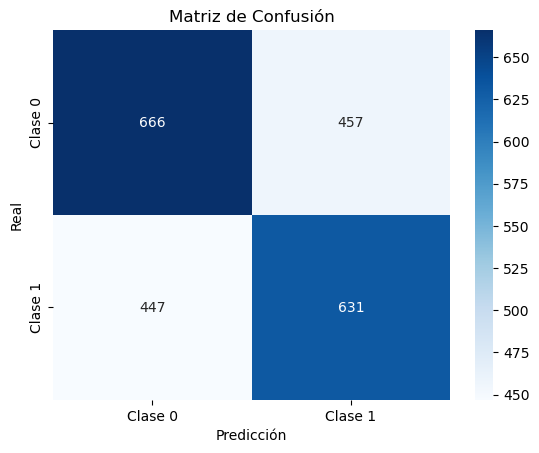

In [182]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = base.predict(X_test)
y_val_prob = base.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Grid search

In [188]:
def train_xgboost_grid(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)


    param_grid = {
    'n_estimators': [100, 250],
    'learning_rate': [0.01, 0.05],  
    'subsample': [0.7, 1.0],  
    'colsample_bytree': [0.5, 0.7, 1.0],  # Añadir 0.5 para más regularización
    'gamma': [0, 0.1],  
    'min_child_weight': [10,35,50],  # Añadir 3 como punto intermedio 
    'reg_alpha': [0.1, 1.0], 
    'reg_lambda': [0.1, 1.0], 
    'scale_pos_weight': [1, scale_pos_weight]  
}


    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return grid_search.best_estimator_,grid_search.best_params_

print("-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --")
best_grid,best_params = train_xgboost_grid(X_train,y_train,X_test,y_test)

print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_grid.predict(X_test)
y_val_prob = best_grid.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Mejores parámetros: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'scale_pos_weight': 1.0610346110904354, 'subsample': 0.7}
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1123
           1       0.64      0.65      0.64      1078

    accuracy                           0.65      2201
   macro avg       0.65      0.65      0.65      2201
weighted avg       0.65      0.65      0.65      2201

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.6460699681962744
F1-Score: 0.6418
AUC-ROC: 0.6880
Precisión: 0.6363
Sensibilidad: 0.6475
Log-loss: 0.6472256704805013
